#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import itertools
import time
import sys

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2046/81850615.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2046/81850615.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### DEFINE PROBLEM PARAMETERS

In [2]:
# Define universal constants:
N_AVOG = 6.022141E+23  # [-]
N_BOLT = 1.380649E-23  # [-]

# Define geometrical parameters:
RADIUS = 1.00E-05  # [m]
LENGTH = 1.00E-03  # [m]

# Define sources intensity:
FISSION_RATE = 3.00E+19                         # [fissions/m^3 s]
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
FUEL_DENSITY = 11040                            # rho [Kg/m^3]
FUEL_SPECIFIC_HEAT = 400                        #Cp [J/(Kg K)]
POWER_DENSITY = FISSION_ENERGY * FISSION_RATE   #q''' [W/m^3]
FISSION_HEAT = FISSION_ENERGY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)    #[K/fissions] = Energia di fissione/(rho Cp)
FISSION_YIELD = 0.24E+00                        #Xenon [at/fissions]  
SOURCE_T = POWER_DENSITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)   #[K/s] = q'''/(rho Cp) 
SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]

# Define temperatur diffusion coefficient and forcing dimensionless group:
FUEL_THERMAL_CONDUCTIVITY = 2.208                                      #[W/(m K)]
ALPHA_T = FUEL_THERMAL_CONDUCTIVITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)  # [m^2 / s]        # = k/(rho Cp)
GAMMA_T = SOURCE_T * LENGTH**2 / ALPHA_T  # [ - ]

# Define reference temperature, concentration and linear diffusion parameters:
T_BC, T_IC = 2.00E+03, 2.00E+03  # [K]
C_BC, C_IC = 0.00E+00, 0.00E+00  # [atm / m^3]

# Define final time, time increment:
TIME_FINAL = 1.00E+07  # [s]
TIME_DELTA = 1.00E+04  # [s]

# Compute number of iterations:
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T):
    return 2.949513e-13 * np.exp(-20487.36244 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2));

#### IDENTIFY DIRICHLET DOFS AND INTERNAL DOFS

In [3]:
# Load coordinates:
coordinates_Px = FFvector_fread('vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([np.linalg.norm(coordinates_Px[ii, :2]) for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_mid_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

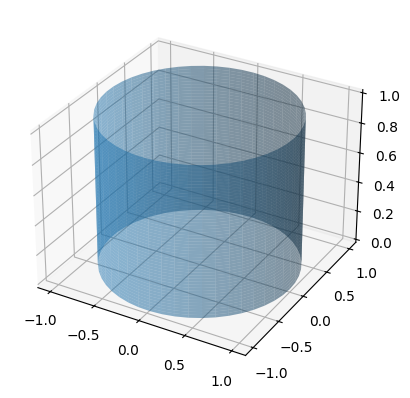

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Xc,Yc,Zc = data_for_cylinder_along_z(0,0,1,1)
ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

plt.show()

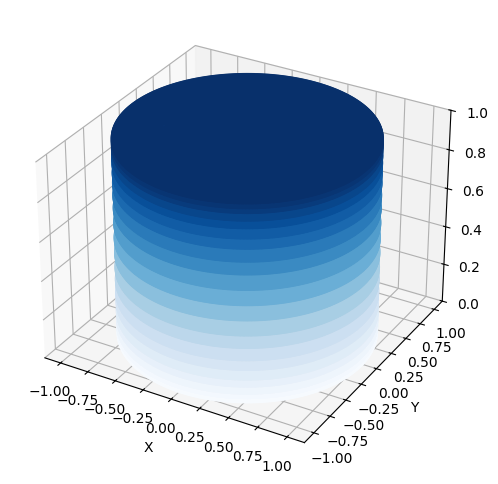

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Estrai le coordinate x, y, z
x = coordinates_Px[:, 0]  # Coordinate x
y = coordinates_Px[:, 1]  # Coordinate y
z = coordinates_Px[:, 2]  # Coordinate z

# Creazione della figura e degli assi con dimensioni maggiori
fig = plt.figure(figsize=(6,6))  # Aumenta le dimensioni della figura
ax = fig.add_subplot(111, projection='3d')

# Crea il grafico a dispersione
sc = ax.scatter(x, y, z, c=z, cmap='Blues', alpha=0.7)

# Etichette degli assi
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Personalizza i limiti dell'asse Z (opzionale, adatta ai tuoi dati)
ax.set_zlim(min(z), max(z))

# Aggiungi la barra dei colori
#fig.colorbar(sc)

# Mostra il grafico
plt.show()

#### IMPORT FINITE ELEMENT ESSENTIALS

In [4]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('ww_mm_Pq.btxt')

# Compute volume of the domain:
volume = mass_Px.dot(np.ones(sFO_Px)).dot(np.ones(sFO_Px))

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('ww_dy_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdz_C = project_Pq.dot(FFmatrix_fread('ww_dz_Px_Pq.btxt')[:, mask_in_C])

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(weights_Pq[:, None]))
inte_C = mass_Px.dot(np.ones((sFO_Px)))[mask_in_C] / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / RADIUS**2 * weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / RADIUS**2 * weights_Pq[:, None])) + \
          PxtoPqdz_C.T.dot(PxtoPqdz_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / LENGTH**2 * weights_Pq[:, None]))

#### IMPLEMENT FULLY IMPLICID FORWARD EULER FOR THE CONCENTRATION ONLY

In [5]:
# Initialise temperature and concentration solution containing the deviation from the initial condition:
sol_new_C = np.zeros((sFO_Px, N_ITER+1)) 
average_C = np.zeros(N_ITER)             #create to save data

# Crea o sovrascrivi il file CSV all'inizio
with open('Sensitivity/10Layers_5Refine_0.75Transition_4Center.csv', 'w') as f:
    f.write('Time (s),Average dC (atm/m^3)\n')  # Intestazione delle colonne

for ii in range(N_ITER):
    cur_time = ii * TIME_DELTA

    # Print current iteration and average temperature and concentration:
    print('Current time:', cur_time, 's')
    average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
    print('Average dC:', average_C[ii], 'atm/m^3\n')

    # Salva i dati correnti nel file CSV
    with open('Sensitivity/10Layers_5Refine_0.75Transition_4Center.csv', 'a') as f:
        f.write(f'{cur_time},{average_C[ii]}\n')

    # Assemble current left-hand-side and right-hand-side
    cur_lhs = mass_C + TIME_DELTA * stiff_C
    cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + TIME_DELTA * (SOURCE_C * forc_C)

    # Compute perturbation from the initial temperature and concentration in the interior of the domain:
    sol_new_C[mask_in_C, ii+1], _ = linalg.bicgstab(cur_lhs, cur_rhs)
    #sol_new_C[mask_in_C, ii+1] = linalg.spsolve(cur_lhs, cur_rhs)
    #sol_new_C[mask_in_C, ii+1], _ = linalg.gmres(cur_lhs, cur_rhs)

# Print final time and final average temperature and concentration:
final_time = N_ITER * TIME_DELTA
final_average_dC = mass_Px.dot(sol_new_C[:, -1]).dot(np.ones((sFO_Px, 1)))[0] / volume

print('Final time:', final_time, 's')
print('Average dC:', final_average_dC, 'atm/m^3')

# Aggiungi i dati finali al file CSV
with open('Sensitivity/10Layers_5Refine_0.75Transition_4Center.csv', 'a') as f:
    f.write(f'{final_time},{final_average_dC}\n')

Current time: 0.0 s
Average dC: 0.0 atm/m^3

Current time: 10000.0 s
Average dC: 6.5401684790644144e+22 atm/m^3

Current time: 20000.0 s
Average dC: 1.276843428050113e+23 atm/m^3

Current time: 30000.0 s
Average dC: 1.8764979102545233e+23 atm/m^3

Current time: 40000.0 s
Average dC: 2.457074866699409e+23 atm/m^3

Current time: 50000.0 s
Average dC: 3.0211498772949227e+23 atm/m^3

Current time: 60000.0 s
Average dC: 3.570528153896797e+23 atm/m^3

Current time: 70000.0 s
Average dC: 4.106570232735897e+23 atm/m^3

Current time: 80000.0 s
Average dC: 4.630346792127817e+23 atm/m^3

Current time: 90000.0 s
Average dC: 5.14273034434467e+23 atm/m^3

Current time: 100000.0 s
Average dC: 5.6444434357204086e+23 atm/m^3

Current time: 110000.0 s
Average dC: 6.136112145618906e+23 atm/m^3

Current time: 120000.0 s
Average dC: 6.618258721393652e+23 atm/m^3

Current time: 130000.0 s
Average dC: 7.091362904816099e+23 atm/m^3

Current time: 140000.0 s
Average dC: 7.555857039217595e+23 atm/m^3

Current t

KeyboardInterrupt: 

OpenFOAM average concentration (@ final time): 4.50696e+24 atm/m^3
Python average concentration (@ final time): 4.510621327059395e+24 atm/m^3
Relative error (@ final time): 0.08124%


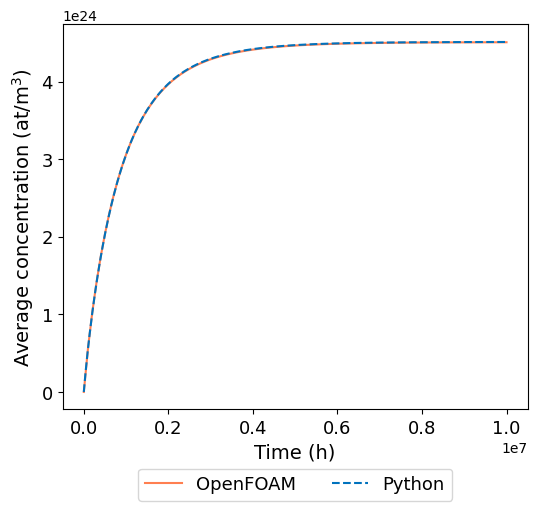

In [7]:
OpenFOAM=np.loadtxt("volFieldValue.dat")     #HF in OpenFOAM
print('OpenFOAM average concentration (@ final time):', OpenFOAM[-1,1], 'atm/m^3')
df = pd.read_csv('Sensitivity/10Layers_5Refine_0.75Transition_4Center.csv')

fig, (ax1) = plt.subplots(1,  figsize=[6,5])
ax1.plot(OpenFOAM[:,0],OpenFOAM[:,1], color='#FF7F50', label='OpenFOAM', linewidth=1.5)
ax1.plot(df['Time (s)'], df['Average dC (atm/m^3)'], '--',color='#0072bd', label='Python', linewidth=1.5)
ax1.set_xlabel('Time (h)', fontsize=14)
ax1.set_ylabel('Average concentration (at/m$^3$)',fontsize=14)
ax1.tick_params(axis="x", labelsize=13)
ax1.tick_params(axis="y", labelsize=13)


ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)


print('Python average concentration (@ final time):', df['Average dC (atm/m^3)'].iloc[-1], 'atm/m^3')
errore_end= (np.abs((OpenFOAM[-1,1]-df['Average dC (atm/m^3)'].iloc[-1]))/(OpenFOAM[-1,1]))*100
print(rf'Relative error (@ final time): {errore_end:.5f}%')

0.01702318584769434


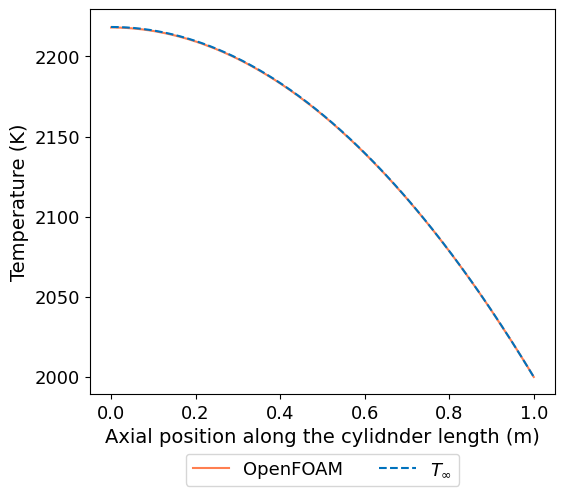

In [16]:
OpenFOAM=pd.read_csv("Temperature_along_z.csv")     

fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(OpenFOAM.iloc[:, -1], OpenFOAM.iloc[:, 0], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1,1001), T_BC + GAMMA_T * (1 - np.linspace(0, 1,1001)**2) / 2, '--',label = '$T_\infty$', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

error = ((np.abs((OpenFOAM.iloc[:, 0]-(T_BC + GAMMA_T * (1 - np.linspace(0, 1,1001)**2) / 2))))/OpenFOAM.iloc[:, 0])*100
print(np.max(error))